# Projet numérique : Calcul Différentiel - Lignes de niveau

*Alexandre Thealler et Camille Srecki*

On cherche à développer un programme python permettant de calculer les __lignes de niveau__ d'une fontion $f$ de deux variables réelles à valeurs réelles supposée continûment différentiable, c'est-à-dire les ensembles de la forme :

$\{(x,y) \in \mathbb{R}^2$ $\vert$  $f(x,y) = c \}$ où $c \in \mathbb{R}$


In [1]:
from math import*
import matplotlib.pyplot as plt
import autograd 
from autograd import numpy as np
from IPython.display import Image 
%matplotlib inline

### Contour Simple

On suppose dans un premier temps que la fontion $f$ est définie dans le __carré unité__ $[0,1]^2$ et on limite notre recherche aux lignes de niveaux qui possèdent un __point sur l'arête gauche du domaine de définition__ (de la forme $(0,y)$ pour $0 \le y \le 1$.) 

#### Amorce 

* On a $f$ une fonction continûment différentiable :

$$\begin{array}{ccccc}
f & : & [0,1]^2 & \to & \mathbb{R} \\
& & (x,y) & \mapsto & f(x,y) \\
\end{array}$$

* On définit $h$ la deuxième application partielle de $f$ au point $(0,0)$. 

$$\begin{array}{ccccc}
h & : & [0,1] & \to & \mathbb{R} \\
& & t & \mapsto & f(0,t) \\
\end{array}$$

$h$ est __continue__ car $f$ est continûment différentiable.

On cherche une condition raisonnable portant sur $f(0,0)$, $f(0,1)$ et $c \in \mathbb{R}$ telle qu'on soit certain qu'il existe un $t \in [0,1]$  tel que $f(0,t) = c$, soit telle que $h(t) = c$.

* Si $c \in [\min_{[0,1]}(h(t)),\max_{[0,1]}(h(t))]$, alors d'après le Théorème des Valeurs Intermédiaires, l'équation $h(t) =c$ pour $t \in [0,1]$ admet au minimum une solution.

* En particulier, si $c \in [\min(h(0),h(1)), \max(h(0),h(1))] \subset [\min_{[0,1]}(h(t)),\max_{[0,1]}(h(t))]$, alors d'après le TVI, l'équation $h(t) =c$ pour $t \in [0,1]$ admet au minimum une solution.

#### Fonction `find_seed`

Cette fonction renvoie un flottant éloigné d'au plus `eps`d'un t en utilisant une méthode de dichotomie et `None`si la condition n'est pas vérifiée sur l'intervalle.

La fonction se base sur un algorithme de dichotomie.

- On part de l'intervalle $[\min(h(0),h(1)), \max(h(0),h(1))]$.
- Si $c$ n'appartient pas à cet intervalle, on renvoie `None`. Sinon, tant que la longueur de l'intervalle est supérieure à `eps`, on coupe l'intervalle en deux et on prend comme nouvel intervalle celui qui contient $c$. Plus précisément, si $(h(debut)-c)(h(t)-c) \leqslant 0$ où $t = \frac{debut - fin}{2}$
- On a alors $fin = t$ et $debut = t$ sinon


In [2]:
def f(x,y):
    return x**2+y**2+1

a=0

def h(t):
    return f(a,t)
    
def find_seed(h, c = 0.0, eps = 2**(-26)): 
    """Cette fonction renvoie un flottant éloigné d'au plus eps d'un t en utilisant 
    une méthode de dichotomie et Nonesi la condition n'est pas vérifiée sur l'intervalle."""
    debut = 0
    fin = 1
    if (c<min(h(debut),h(fin))) or (c>max(h(debut),h(fin))): 
        return None
    ecart = fin-debut
    while (ecart > eps):
        t = (debut+fin)/2
        if (h(debut)-c)*(h(t)-c)<=0:
            fin = t
        else:
            debut = t
        ecart = fin-debut
    return t 

find_seed(h, c = 1.5, eps = 2**(-26))

0.7071067839860916

#### Propagation

*Méthode :* 

On se place sur l'espace $[0,1]^2$. On a trouvé par dichotomie la **racine de la fonction** sur l'arête gauche gràce à la fonction `find_seed`. On calcule le **gradient** de la fonction, supposé non nul, en ce point puis son **orthogonale**, qui correspond à la **tangente** en ce point de la fonction. On se déplace d'un entier `delta` sur la tangente puis à l'aide de la méthode de Newton, on cherche le point le plus proche qui appartient à la courbe de niveau. 

*Mise en application :*

On cheche à implémenter une fonction qui renvoie un fragment de ligne de niveau de valeur $c$ de $f$ sous la forme de deux tableaux à une dimension d'abscisses et d'ordonnées de points de cette ligne, approximativement espacés de `delta`. Si un tel fragment ne peut être généré, la fonction renvoie deux tableaux vides.

On définit quelques fonctions qui serviront à la lisibilité du code.

In [3]:
def grad(f, x, y):
    """Renvoie le gradient d'un point de coordonnées (x,y) sous forme de np.array"""
    g = autograd.grad 
    return np.array([g(f,0)(x,y), g(f,1)(x,y)])
    
def perpendiculaire(v):
    """Renvoie le vecteur orthogonal à v """
    return np.array([v[1],-v[0]])

def fin_ligne(x,y,delta):
    """Prend en argument x et y des array et renvoie un booléen qui indique si le dernier point
    de x et y appartient toujours au carré [0,1]x[0,1] à delta près."""
    if (x[-1] > 1-delta) or (x[-1] < delta) or (y[-1] > 1-delta) or (y[-1] < delta):
        return False
    else:
        return True

def distance(x,y,a,b):
    """Renvoie la distance euclidienne"""
    return (sqrt((x-a)**2+(y-b)**2))

#### Algorithme de `simple_contour_propagation` 

Dans ce cas, les coordonnées trouvées pour le point suivant ne sont pas les bonnes. L'erreur se propage en raison de l'imprécision de la méthode du gradient. 

![title](newton.jpg)

De plus, pour chaque gradient calculé, il existe deux vecteurs orthogonaux possibles. On veillera alors à prendre celui dont la distance par rapport au point précédent était maximale. Il est ensuite nécessaire de le normaliser par la valeur `delta`.

In [4]:
def simple_contour_propagation(f, c = 0.0, delta=0.01): 
    """Renvoie la liste des points de la courbe de niveau sans faire appel à la méthode de Newton-"""
    x1 = []
    y1 = []
    a = 0
    def h(t):
        return f(a,t)
    t = find_seed(h,c=1.5,eps=2**(-26))
    x1.append(0.0)
    y1.append(t) #on a ajouté le premier point du contour sur l'axe x=0
    gradient=grad(f,0.0,t)
    perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
    x1.append(perp[0]+x1[-1])
    y1.append(perp[1]+y1[-1])
    #là il faudrait faire le newton
    while fin_ligne(x1,y1,delta)==True:
        gradient=grad(f,float(x1[-1]),float(y1[-1]))
        perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
        perp2=-perp
        #on choisit le "bon" contour
        if distance(x1[-1],y1[-1],perp[0]+x1[-1],perp[0]+y1[-1]) < distance(x1[-1],y1[-1],perp2[0]+x1[-1],perp2[0]+y1[-1]):
            x1.append(perp2[0]+x1[-1])
            y1.append(perp2[1]+y1[-1])
        else:
            x1.append(perp[0]+x1[-1])
            y1.append(perp[1]+y1[-1])
        #il faudraitfaire le newton
    x=np.array(x1)
    y=np.array(y1)
    return x,y

La **méthode de Newton** permet de trouver le point le plus proche appartenant véritablement à la courbe.

*Principe*:
De manière générale, si $F$ est une fonction de la forme :

$$\begin{array}{ccccc}
F & : & \mathbb{R}^2 & \to & \mathbb{R}^2 \\
& & (x_1,x_2) & \mapsto & (f(x_1,x_2),g(x_1,x_2)) \\
\end{array}$$

On cherche $(S_1,S_2)$ tels que $F(S_1,S_2) = 0_{\mathbb{R}^2}$

On définit la matrice Jacobienne de $F$ par :
$\forall (x_1,x_2) \in  \mathbb{R}^2, J(x_1,x_2) =
\begin{pmatrix}
\frac{\partial F_1(x_1,x_2)}{\partial x_1} & \frac{\partial F_1(x_1,x_2)}{\partial x_2} \\
\frac{\partial F_2(x_1,x_2)}{\partial x_1} & \frac{\partial F_2(x_1,x_2)}{\partial x_2}
\end{pmatrix}$

La méthode de Newton consiste donc à calculer les itérations successives de la suite définie par :

$$\begin{pmatrix}
x_{1,n+1} \\
x_{2,n+1}
\end{pmatrix}
=
\begin{pmatrix}
x_{1,n} \\
x_{2,n}
\end{pmatrix}
- J(x_{1,n},x_{2,n})^{-1} 
\begin{pmatrix}
F_1(x_{1,n},x_{2,n}) \\
F_2({1,n},x_{2,n})
\end{pmatrix}$$

Et on montre que 
$\lim\limits_{x \to \inf} 
\begin{pmatrix}
x_{1,n} \\
x_{2,n}
\end{pmatrix}
=
\begin{pmatrix}
S_1 \\
S_2
\end{pmatrix}$

Dans notre étude, $F$ est définie par :

$$\begin{array}{ccccc}
F & : & \mathbb{R}^2 & \to & \mathbb{R}^2 \\
& & \begin{pmatrix}
x \\
y
\end{pmatrix} & \mapsto & \begin{pmatrix}
f(x,y) -c \\
\sqrt{(x-x_0)^2 + (y-y_0)^2}
\end{pmatrix}
\\
\end{array}$$

où $(x_0,y_0)$ correspond au dernier point de la ligne de niveau stocké en mémoire.

In [5]:
def newton(f,x,y,c,delta,eps=2**(-26)): 
    """Applique l'algorithme de Newton pour trouver un point (a,b) 
    situé à une distance de plus de delta du précédent. 
    L'écart de la fonction f appliquée en (a,b) à c doit être inférieur à eps."""
    def F(a,b):
        return (f(a,b)-c,distance(x,y,a,b))
    def J_F(a,b):
        j=autograd.jacobian
        return np.c_[j(f,0)(a,b),j(f,1)(a,b)]
    a=x
    b=y
    while F(a,b)[0]>eps and F(a,b)[1]>delta:
        inverse_jacobienne=np.linlg(J_F(a,b))
        inter=(np.array([a,b])-np.dot(inverse_jacobienne,F(a,b)))[0]
        b=(np.array([a,b])-np.dot(inverse_jacobienne,F(a,b)))[1]
        a=inter
    return np.array([a,b])

#### Algorithme de `simple_contour_bug`

Ainsi en implémentant la méthode de Newton à l'algorithme précédent, mais sans choisir systématiquement le bon vecteur orthogonal au gradient, on obtient un bug.

Text(0.5,1,'Courbe de niveau de niveau de la fonction $x^2 + y^2$ pour $c=0.3$')

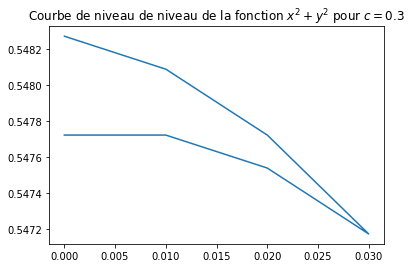

In [6]:
def simple_contour_bug(f, c = 0.0, delta=0.01):#erreur du au choix de perp
    x1 = []
    y1 = []
    a = 0
    def h(t):
        return f(a,t)
    t = find_seed(h,c=0.3,eps=2**(-26))
    x1.append(0.0)#à modifier pour la fct contour
    y1.append(t)#on a ajouté le premier point du contour sur l'axe x=0
    gradient=grad(f,0.0,t)
    perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
    x1_inter=perp[0]+x1[-1]
    y1_inter=perp[1]+y1[-1]
    l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
    x1.append(l[0])
    y1.append(l[1])
    while fin_ligne(x1,y1,delta)==True:
        gradient=grad(f,float(x1[-1]),float(y1[-1]))
        perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
        perp2=-perp
        #on choisit le "bon" contour
        if distance(x1[-1],y1[-1],perp[0]+x1[-1],perp[0]+y1[-1]) < distance(x1[-1],y1[-1],perp2[0]+x1[-1],perp2[0]+y1[-1]):
            x1_inter=perp[0]+x1[-1]
            y1_inter=perp[1]+y1[-1]
            l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
            x1.append(l[0])
            y1.append(l[1])
        else:
            x1_inter=perp2[0]+x1[-1]
            y1_inter=perp2[1]+y1[-1]
            l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
            x1.append(l[0])
            y1.append(l[1])
    x=np.array(x1)
    y=np.array(y1)
    return x,y


f = lambda x,y : x**2 + y**2
x,y = simple_contour_bug(f, c=0.3, delta = 0.01)
plt.plot(x,y)
plt.title("Courbe de niveau de niveau de la fonction $x^2 + y^2$ pour $c=0.3$")



#### Algorithme de `simple_contour`

Cette fois, on corrige l'erreur de l'algorithme précédent en choisissant le bon vecteur perpendiculaire.

(-0.027773956926976352,
 0.58325309546650339,
 -0.020506197692472153,
 0.574781075568498)

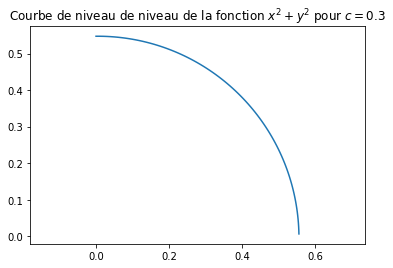

In [7]:
def simple_contour_incomplet(f, c = 0.0, delta=0.01): #en réalité, rien ne nous garantit que t appartient à l'axe (0,y)
    x1 = []
    y1 = []
    test=True #ce booléen permettra de choisir quel vecteur perpendiculaire choisir
    a = 0
    def h(t):
        return f(a,t)
    t = find_seed(h,c=0.3,eps=2**(-26))
    x1.append(0.0)
    y1.append(t)#on a ajouté le premier point du contour sur l'axe x=0
    gradient=grad(f,0.0,t)
    perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
    x1_inter=perp[0]+x1[-1]
    y1_inter=perp[1]+y1[-1]
    l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
    x1.append(l[0])
    y1.append(l[1])
    test=fin_ligne(x1,y1,delta)
    if test==True:
        while fin_ligne(x1,y1,delta)==True: #même commentaire que pour x1.append(0.0)
            gradient=grad(f,float(x1[-1]),float(y1[-1]))
            perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
            x1_inter=perp[0]+x1[-1]
            y1_inter=perp[1]+y1[-1]
            l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
            x1.append(l[0])
            y1.append(l[1])
    else:#on choisit l'autre vecteur perpendiculaire
        x1.pop()
        y1.pop()
        x1_inter=perp[0]+x1[-1]
        y1_inter=perp[1]+y1[-1]
        l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
        x1.append(l[0])
        y1.append(l[1])
        while fin_ligne(x1,y1,delta)==True:
            gradient=grad(f,float(x1[-1]),float(y1[-1]))
            perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
            perp2=-perp
            x1_inter=perp2[0]+x1[-1]
            y1_inter=perp2[1]+y1[-1]
            l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
            x1.append(l[0])
            y1.append(l[1])
    x=np.array(x1)
    y=np.array(y1)
    return x,y

f = lambda x,y : x**2+y**2

x,y = simple_contour_incomplet(f, c=0.3, delta = 0.01)
plt.plot(x,y)
plt.title("Courbe de niveau de niveau de la fonction $x^2 + y^2$ pour $c=0.3$")
plt.axis('equal') 

   
 

(-0.027773956926976352,
 0.58325309546650339,
 -0.020506197692472153,
 0.574781075568498)

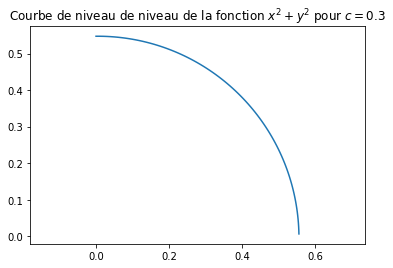

In [8]:
def simple_contour(f, c = 0.0, delta=0.01): 
    x1 = []
    y1 = []
    test=True #ce booléen permettra de choisir quel vecteur perpendiculaire choisir
    def h(t):
        return f(0,t)
    t1 = find_seed(h,c=0.3,eps=2**(-26)) #axe x=0
    def i(t):
        return f(1,t)
    t2 = find_seed(i,c=0.3,eps=2**(-26)) #axe x=1
    def j(t):
        return f(t,0)
    t3 = find_seed(j,c=0.3,eps=2**(-26)) #axe y=0
    def k(t):
        return f(t,1)
    t4 = find_seed(k,c=0.3,eps=2**(-26)) #axe y=1
    if t1!=None:
        a=0.0
        b=float(t1)
    elif t2!=None:
        a=1.0
        b=float(t2)
    elif t3!=None:
        a=float(t3)
        b=0.0
    elif t4!=None:
        a=float(t4)
        b=1.0
    else:
        return np.array([]),np.array([])
    x1.append(a)
    y1.append(b)#on a ajouté le premier point du contour sur l'axe x=0
    gradient=grad(f,a,b)
    perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
    x1_inter=perp[0]+x1[-1]
    y1_inter=perp[1]+y1[-1]
    l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
    x1.append(l[0])
    y1.append(l[1])
    test=fin_ligne(x1,y1,delta)
    if test==True:
        while fin_ligne(x1,y1,delta)==True: #même commentaire que pour x1.append(0.0)
            gradient=grad(f,float(x1[-1]),float(y1[-1]))
            perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
            x1_inter=perp[0]+x1[-1]
            y1_inter=perp[1]+y1[-1]
            l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
            x1.append(l[0])
            y1.append(l[1])
    else:#on choisit l'autre vecteur perpendiculaire
        x1.pop()
        y1.pop()
        x1_inter=perp[0]+x1[-1]
        y1_inter=perp[1]+y1[-1]
        l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
        x1.append(l[0])
        y1.append(l[1])
        while fin_ligne(x1,y1,delta)==True:
            gradient=grad(f,float(x1[-1]),float(y1[-1]))
            perp=perpendiculaire(gradient)*delta/np.linalg.norm(gradient)
            perp2=-perp
            x1_inter=perp2[0]+x1[-1]
            y1_inter=perp2[1]+y1[-1]
            l=newton(f,x1_inter,y1_inter,2**(-26),delta,c)
            x1.append(l[0])
            y1.append(l[1])
    x=np.array(x1)
    y=np.array(y1)
    return x,y

f = lambda x,y : x**2+y**2

x,y = simple_contour(f, c=0.3, delta = 0.01)
plt.plot(x,y)
plt.title("Courbe de niveau de niveau de la fonction $x^2 + y^2$ pour $c=0.3$")
plt.axis('equal') 
   

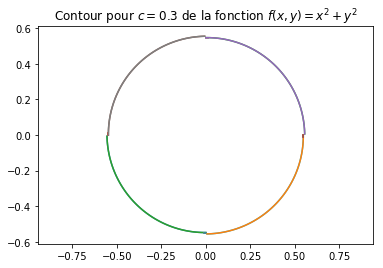

In [14]:
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function

def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

level_curves = contour(f, c=0.3, xs=[-1.0,0.0, 1.0], ys=[-1.0,0.0, 1.0], delta=0.01)
for x, y in level_curves:
    plt.plot(x, y)
    plt.axis('equal')
    plt.title('Contour pour $c=0.3$ de la fonction $f(x,y)=x^2+y^2$')

on constate que la courbe n'est pas parfaitement continue.